# Hyperparameters optimisation
## TD 5

This is the version of the TD where I use as many images as last time (not the big .zip) (https://drive.google.com/drive/u/1/folders/1kMhMH5pi_jJNgwNPpy1epXsWCI4Hqsve).

We are essentially going to use the same `Food101` ([credit where it's due](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/)) data, the same object `ImageDataset`, the same `DataLoader`.

The code below is mainly a copy of the code from the previous TD, except that global variables are now defined separately and everything is wrapped in different functions. This is to make it easier to train the same model with different hyperparameters and architectures, etc ...

For those that can use their GPUs or are on the DCE, all the necessary `.to(device)` are already in the code.

If, for some reason, you encounter this error: `OutOfMemoryError: CUDA out of memory.`, it means that your GPU does not have enough memory to run the model. You can try to reduce the batch size, or the number of neurons in the network, or the number of layers in the network, or the number of filters in the convolutional layers, etc ...

In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import pathlib
import time
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Set the random seed for reproducibility
_ = torch.manual_seed(25)

In [2]:
from functools import partial
print = partial(print, flush=True)

In [3]:
# Global variables

# Setup device-agnostic code
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {DEVICE} device")

# Batch size
BATCH_SIZE = 512

# Learning rate
LEARNING_RATE = 2e-2

# Number of epochs
NUM_EPOCHS = 20

# Number of classes
NUM_CLASSES = 3

# Image size
IMAGE_SIZE = 128

Using cuda device


In [ ]:
class CachedImageFolder(datasets.ImageFolder):
    # We're losing something by doing that, what is it? (A: The datatransforms) How could we fix it? (A: Write your own Dataset)
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.cache = {}

    def __getitem__(self, index):
        if index not in self.cache:
            self.cache[index] = super().__getitem__(index)
        return self.cache[index]

In [5]:
def get_datasets_and_dataloaders(
    batch_size: int = 4
) -> tuple[
    DataLoader, 
    DataLoader
]:
    """
    Load the training and test datasets into data loaders.
    """
    data_dir = pathlib.Path(".")
    train_dir = data_dir / "Food-3" / "train"
    test_dir = data_dir / "Food-3" / "test"

    data_transform_train = transforms.Compose(
        [
            transforms.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),  # Resize the images to 128x128
            transforms.ToTensor(),  # Convert the images to tensors
            transforms.RandomHorizontalFlip(p=0.5),  # Flip the images horizontally with probability 0.5
        ]
    )
    data_transform_test = transforms.Compose(
        [
            transforms.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),  # Resize the images to 128x128
            transforms.ToTensor(),  # Convert the images to tensors
        ]
    )

    train_data = CachedImageFolder(
        root=str(train_dir),  # target folder of images
        transform=data_transform_train,  # transforms to perform on data (images)
        target_transform=None  # transforms to perform on labels (if necessary)
    ) 

    test_data = CachedImageFolder(
        root=str(test_dir),
        transform=data_transform_test
    )

    train_dataloader = DataLoader(
        dataset=train_data,
        batch_size=batch_size,  # how many samples per batch?
        shuffle=True  # shuffle the data?
    )

    test_dataloader = DataLoader(
        dataset=test_data,
        batch_size=batch_size,
        shuffle=False
    ) # don't usually need to shuffle testing data


    return train_dataloader, test_dataloader

In [6]:
# Load dataloaders in global variables
TRAIN_DATALOADER, TEST_DATALOADER = get_datasets_and_dataloaders(BATCH_SIZE)

In [7]:
# How can we get the datasets? Did we lose them? No
print(TRAIN_DATALOADER.dataset)
print("---")
print(TEST_DATALOADER.dataset)

Dataset CachedImageFolder
    Number of datapoints: 2712
    Root location: Food-3\train
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               RandomHorizontalFlip(p=0.5)
           )
---
Dataset CachedImageFolder
    Number of datapoints: 306
    Root location: Food-3\test
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


In [8]:
example_tensor = torch.tensor(
    [
        [1, 2, 3, 4],
        [5, 6, 7, 8],
        [9, 10, 11, 12],
        [13, 14, 15, 16]
    ], 
    dtype=torch.float32
)

# First let's go to our configuration: tensor of shape (batch_size, channels, height, width)
print(example_tensor.shape)
example_tensor = example_tensor.unsqueeze(0).unsqueeze(0)  # (N, C, H, W)
print(example_tensor.shape)

# Conv2d with a 2x2 kernel
conv = nn.Conv2d(
    in_channels=1,
    out_channels=1,
    kernel_size=2
)

output = conv(example_tensor)
print(output.shape)
output = output.squeeze()
print(output.shape)

print(output)

torch.Size([4, 4])
torch.Size([1, 1, 4, 4])
torch.Size([1, 1, 3, 3])
torch.Size([3, 3])
tensor([[-0.1947, -0.2754, -0.3561],
        [-0.5174, -0.5981, -0.6788],
        [-0.8402, -0.9209, -1.0015]], grad_fn=<SqueezeBackward0>)


In [9]:
example_tensor = torch.tensor(
    [
        [1, 2, 3, 4],
        [5, 6, 7, 8],
        [9, 10, 11, 12],
        [13, 14, 15, 16]
    ], 
    dtype=torch.float32
)

# First let's go to our configuration: tensor of shape (batch_size, channels, height, width)
print(example_tensor.shape)
example_tensor = example_tensor.unsqueeze(0).unsqueeze(0)
print(example_tensor.shape)

# max_pool2d with a 2x2 kernel
pool = nn.MaxPool2d(kernel_size=2)
pooled_tensor = pool(example_tensor)
print(pooled_tensor.shape)

pooled_tensor = pooled_tensor.squeeze()
pooled_tensor, pooled_tensor.shape

torch.Size([4, 4])
torch.Size([1, 1, 4, 4])
torch.Size([1, 1, 2, 2])


(tensor([[ 6.,  8.],
         [14., 16.]]),
 torch.Size([2, 2]))

In [10]:
class Net(nn.Module):
    def __init__(
        self,
        hidden_units: int = 200,
        batch_norm: bool = False,
        use_conv: bool = False
    ):
        super().__init__()

        self.use_conv: bool = use_conv
        self.batch_norm: bool = batch_norm

        if use_conv:
            self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=not batch_norm)
            self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1, bias=not batch_norm)

            if batch_norm:
                self.bn1 = nn.BatchNorm2d(16)
                self.bn2 = nn.BatchNorm2d(32)

            self.pool = nn.MaxPool2d(kernel_size=2)
            conv_output_size = IMAGE_SIZE // 4  # (we will add two poolings of size (2, 2))

            self.fc1 = nn.Linear(32 * conv_output_size * conv_output_size, hidden_units)
        else:
            self.fc1 = nn.Linear(IMAGE_SIZE * IMAGE_SIZE * 3, hidden_units, bias=not batch_norm)
            
            if batch_norm:
                self.bn1 = nn.BatchNorm1d(hidden_units)

        # Shared layers
        self.fc2 = nn.Linear(hidden_units, NUM_CLASSES)

    def forward(self, x):
        if self.use_conv:
            x = self.conv1(x)
            if self.batch_norm:
                x = self.bn1(x)
            x = nn.ReLU()(x)
            x = self.pool(x)

            x = self.conv2(x)
            if self.batch_norm:
                x = self.bn2(x)
            x = nn.ReLU()(x)
            x = self.pool(x)

            # Flatten the features for the fully connected layer
            x = x.view(x.size(0), -1)

            x = self.fc1(x)
            x = nn.ReLU()(x)

        else:
            # Flatten in the beginning for the fully connected layer
            x = x.view(x.size(0), -1)
            x = self.fc1(x)
            if self.batch_norm:
                x = self.bn1(x)
            x = nn.ReLU()(x)

        x = self.fc2(x)
        return x

---

Why does it not work with `x = x.view(BATCH_SIZE, -1)`?

---

In [11]:
# Create model
MODEL: Net = Net(hidden_units=200, batch_norm=False, use_conv=False).to(DEVICE)

In [12]:
def test_our_model() -> float:
    # 0. Put model in eval mode
    MODEL.eval()  # to remove stuff like dropout that's only going to be in the training part

    # 1. Setup test accuracy value
    test_acc: float = 0

    # 2. Turn on inference context manager
    with torch.no_grad():
        # Loop through DataLoader batches
        for X_test, y_test in TEST_DATALOADER:  # majuscule à X car c'est une "matrice", et y un entier
            # a. Move data to device and no need to reshape since it's done in MODEL definition
            X_test_flattened = X_test.to(DEVICE) 
            y_test = y_test.to(DEVICE)

            # b. Forward pass
            model_output = MODEL(X_test_flattened)

            # c. Calculate and accumulate accuracy
            test_pred_label = model_output.argmax(dim=1)
            test_acc += (test_pred_label == y_test).sum()

    # Adjust metrics to get average loss and accuracy per batch
    test_acc = (test_acc.cpu() / (len(TEST_DATALOADER.dataset))).item()
    return test_acc

In [13]:
# Test our untrained model
print((f"{100*test_our_model():.2f}%"))

34.31%


You should get 34.31% accuracy on the testing set without training and with the default hyperparameters if you used the same seed. Close enough to 33% which is the expected accuracy for a random classifier.

We can plot some images like last time

torch.Size([3, 128, 128])
torch.Size([128, 128, 3])


Text(0.5, 1.0, 'pizza')

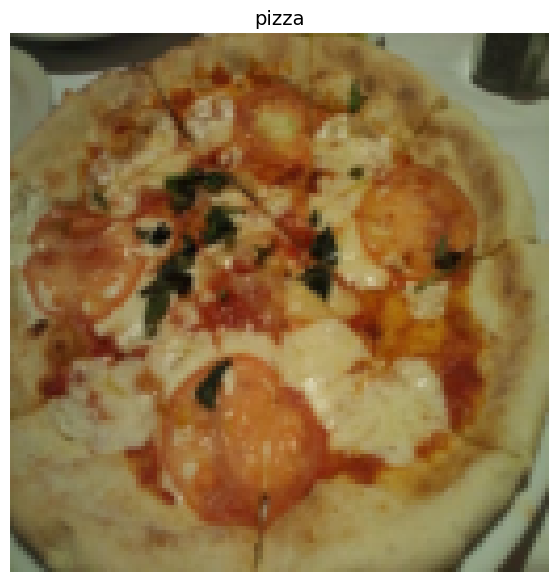

In [14]:
# Get the tensors and put them in the right dimensions for matplotlib
my_pizza = TRAIN_DATALOADER.dataset[0][0]
my_label = TRAIN_DATALOADER.dataset[0][1]
print(my_pizza.shape)
my_pizza_reshaped = my_pizza.permute(1, 2, 0)
print(my_pizza_reshaped.shape)

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(my_pizza_reshaped)
plt.axis("off")
plt.title(TRAIN_DATALOADER.dataset.classes[my_label], fontsize=14)

Let's do the training loop now

In [15]:
def main_train(loss_fn, optimizer) -> None:
    """
    Train the model and modifies the trained model inplace.
    """
    start_time_global = time.time()

    # Put model in train mode
    MODEL.train()

    # Loop through data loader data batches
    for epoch in range(NUM_EPOCHS):
        start_time_epoch = time.time()

        # Setup train loss and train accuracy values
        train_loss, train_acc = 0, 0

        for X, y in TRAIN_DATALOADER:
            # 0. Move data to device
            X = X.to(DEVICE)
            y = y.to(DEVICE)

            # 1. Forward pass
            y_pred = MODEL(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(y_pred, y)
            train_loss += loss.item()

            # 3. Optimizer zero grad
            optimizer.zero_grad()

            # 4. Loss backward
            loss.backward()

            # 5. Optimizer step
            optimizer.step()

            # Calculate and accumulate accuracy metric across all batches
            y_pred_class = y_pred.argmax(dim=1)
            train_acc += (y_pred_class == y).sum()

        # Adjust metrics to get average loss and accuracy per batch
        train_loss = train_loss / (len(TRAIN_DATALOADER.dataset))
        train_acc = train_acc / (len(TRAIN_DATALOADER.dataset))
        print(
            f"epoch {epoch+1}/{NUM_EPOCHS},"
            f" train_loss = {train_loss:.2e},"
            f" train_acc = {100*train_acc.item():.2f}%,"
            f" time spent during this epoch = {time.time() - start_time_epoch:.2f}s,"
            f" total time spent = {time.time() - start_time_global:.2f}s"
        )

In [16]:
main_train(nn.CrossEntropyLoss(), torch.optim.SGD(MODEL.parameters(), lr=LEARNING_RATE))

epoch 1/20, train_loss = 3.33e-03, train_acc = 35.21%, time spent during this epoch = 5.54s, total time spent = 5.54s
epoch 2/20, train_loss = 2.38e-03, train_acc = 40.49%, time spent during this epoch = 0.10s, total time spent = 5.64s
epoch 3/20, train_loss = 2.40e-03, train_acc = 43.33%, time spent during this epoch = 0.07s, total time spent = 5.71s
epoch 4/20, train_loss = 2.22e-03, train_acc = 54.35%, time spent during this epoch = 0.08s, total time spent = 5.79s
epoch 5/20, train_loss = 2.20e-03, train_acc = 50.66%, time spent during this epoch = 0.07s, total time spent = 5.86s
epoch 6/20, train_loss = 2.22e-03, train_acc = 47.42%, time spent during this epoch = 0.07s, total time spent = 5.94s
epoch 7/20, train_loss = 2.20e-03, train_acc = 49.59%, time spent during this epoch = 0.07s, total time spent = 6.01s
epoch 8/20, train_loss = 2.05e-03, train_acc = 57.19%, time spent during this epoch = 0.09s, total time spent = 6.10s
epoch 9/20, train_loss = 2.10e-03, train_acc = 52.88%, t

In [17]:
print((f"{100*test_our_model():.2f}%"))

58.17%


You should get 58.17% accuracy on the testing set without training and with the default hyperparameters if you used the same seed. And we definitely reached convergence (the loss is not decreasing that much anymore, and if you try to train for more epochs, you will see that the testing set accuracy will decrease). Note that by saying "if you try to train for more epochs, you will see that the testing set accuracy will decrease", we kind of cheated by using the testing set to infer an information about the number of epochs, we should instead use validation sets and cross validation techniques ... and we will (today)! No worries.

-----

Is it possible for `train_loss` to decrease whilst `train_acc` decreases at the same time? Look at what happens between epochs 14 and 15 in this example (it's a real run, different seed though):
```py
epoch 14/15, train_loss = 1.01e-01, train_acc = 63.61%, time spent ...
epoch 15/15, train_loss = 9.91e-02, train_acc = 63.50%, time spent ...
```

Why is that?

-----

## Let's try to improve this accuracy!

You will need to install the Optuna package (`pip install optuna`) and import it at the beginning of your script (no need if you're using the shared environment of the DCE, we installed it for you already). We should also import `KFold` from `sklearn.model_selection`. This is because we will use cross-validation to find the best hyperparameters.

In [18]:
import optuna
from sklearn.model_selection import KFold

First easy task is to decide how many neurons there should be in the hidden layer.
 
We will do this together (optimising the number of hidden nuerons), and then you'll have to implement optimization of the learning rate*, the optimizer's choice on your own. We will also show you how to choose between a convolutional and dense network.

\**Careful! Small learning rates are not always better, especially if you do not change the number of epochs. You should try to find the best learning rate for the number of epochs you chose, one that is not too big for your computer to handle.*

We will need to define a new function that will be used as the objective function for Optuna's optimization. This function should take in the `trial` object from Optuna as an argument and use the `trial` object to define and sample the hyperparameters that you want to optimize. For example, you can use the `trial` object to sample a choice between a convolutional and dense network, and to sample the number of neurons for the chosen network. After training the model, we will need to return the final validation accuracy calculated with cross-validation* as the objective function value for Optuna to maximise.

\*We use cross-validation here (5-fold) because we want to use the testing set as little as possible. We will use the testing set only once, at the end, to get the final accuracy of the best model. But, cross-validation greatly increases the time required to run the algorithms, so we won't always use cross-validation to optimize hyperparameters.

In [19]:
def objective(trial: optuna.trial.Trial) -> float:
    print("New trial")

    # Set up cross validation
    n_splits: int = 5
    fold = KFold(n_splits=n_splits, shuffle=True, random_state=0)
    scores = [0]*n_splits

    hidden_units: int = trial.suggest_int('hidden_units', 2, 50)

    # Loop through data loader data batches
    for fold_idx, (train_idx, valid_idx) in enumerate(fold.split(range(len(TRAIN_DATALOADER.dataset)))):
        # train_idx and valid_idx are numpy arrays of indices of the training and validation sets for this 
        # fold respectively.
        # They do not contain the actual data, but the indices of the data in the dataset.
        # We can use these indices to create a subset of the dataset for this fold with torch.utils.data.Subset.
        # Obviously, if an index is in the validation set, it will not be in the training set. You could
        # check this by printing train_idx and valid_idx and check by yourself.
        
        print(f"Fold {fold_idx+1}/{n_splits}")

        # Create subsets of the dataset for this fold
        sub_train_data = torch.utils.data.Subset(TRAIN_DATALOADER.dataset, train_idx)
        sub_valid_data = torch.utils.data.Subset(TRAIN_DATALOADER.dataset, valid_idx)

        # Create data loaders for this fold
        sub_train_loader = torch.utils.data.DataLoader(sub_train_data, batch_size=BATCH_SIZE, shuffle=True)
        sub_valid_loader = torch.utils.data.DataLoader(sub_valid_data, batch_size=BATCH_SIZE, shuffle=False)
        
        # Generate the model.
        my_model: Net = Net(hidden_units=hidden_units).to(DEVICE)
        
        for epoch in range(NUM_EPOCHS):
            # Training of the model.
            # Put model in train mode
            my_model.train()

            # Set up optimizer
            optimizer = torch.optim.SGD(my_model.parameters(), lr=LEARNING_RATE)

            # Set up loss function
            loss_fn = nn.CrossEntropyLoss()
            for X, y in sub_train_loader:
                # 1. Move data to device
                X = X.to(DEVICE)
                y = y.to(DEVICE)

                # 2. Forward pass
                y_pred = my_model(X)

                # 3. Calculate and accumulate loss
                loss = loss_fn(y_pred, y)

                # 4. Optimizer zero grad
                optimizer.zero_grad()

                # 5. Loss backward
                loss.backward()

                # 6. Optimizer step
                optimizer.step()

        # Validation of the model.
        # Put model in eval mode
        my_model.eval()
        
        val_acc = 0
        with torch.no_grad():
            for X, y in sub_valid_loader:
                # 1. Move data to device
                X = X.to(DEVICE)
                y = y.to(DEVICE)

                # 2. Forward pass
                y_pred = my_model(X)
                
                # 3. Compute accuracy
                y_pred_class = y_pred.argmax(dim=1)

                val_acc += (y_pred_class == y).sum()

        scores[fold_idx] = (val_acc.cpu() / len(sub_valid_data))
        # bring it back otherwise, np.mean will not work
        print(f"Fold {fold_idx+1}/{n_splits} accuracy: {scores[fold_idx]}")
    
    return np.mean(scores)

Finally, we will need to call the `optuna.create_study()` function to create a new study, and use the `study.optimize()` function to run the optimization, passing the objective function that we defined earlier.

You can find more information about how to use Optuna in the [Optuna documentation](https://optuna.readthedocs.io/en/stable/index.html).

In [20]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, timeout=1200, n_trials=15) 
# - timeout = 1200 -> stops after 20 minutes;
# - n_trials = 5 -> tries 5 different values for the hyperparameter.

pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("\n")
print("--------------------")
print("--------------------")
print("--------------------")
print("\n")
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print(f"\t{key}: {value}")

[I 2026-01-18 14:09:05,005] A new study created in memory with name: no-name-6c7963ac-2b6b-437b-ba88-b5c7bae364ea


New trial
Fold 1/5
Fold 1/5 accuracy: 0.47329649329185486
Fold 2/5
Fold 2/5 accuracy: 0.5580110549926758
Fold 3/5
Fold 3/5 accuracy: 0.5313653349876404
Fold 4/5
Fold 4/5 accuracy: 0.5885608792304993
Fold 5/5
Fold 5/5 accuracy: 0.49815496802330017


[I 2026-01-18 14:09:10,962] Trial 0 finished with value: 0.5298777222633362 and parameters: {'hidden_units': 29}. Best is trial 0 with value: 0.5298777222633362.


New trial
Fold 1/5
Fold 1/5 accuracy: 0.47329649329185486
Fold 2/5
Fold 2/5 accuracy: 0.5469613075256348
Fold 3/5
Fold 3/5 accuracy: 0.5055350661277771
Fold 4/5
Fold 4/5 accuracy: 0.40774908661842346
Fold 5/5
Fold 5/5 accuracy: 0.4833948314189911


[I 2026-01-18 14:09:16,884] Trial 1 finished with value: 0.4833873212337494 and parameters: {'hidden_units': 17}. Best is trial 0 with value: 0.5298777222633362.


New trial
Fold 1/5
Fold 1/5 accuracy: 0.5635359287261963
Fold 2/5
Fold 2/5 accuracy: 0.4217311143875122
Fold 3/5
Fold 3/5 accuracy: 0.3357933461666107
Fold 4/5
Fold 4/5 accuracy: 0.39114391803741455
Fold 5/5
Fold 5/5 accuracy: 0.468634694814682


[I 2026-01-18 14:09:22,673] Trial 2 finished with value: 0.43616780638694763 and parameters: {'hidden_units': 20}. Best is trial 0 with value: 0.5298777222633362.


New trial
Fold 1/5
Fold 1/5 accuracy: 0.521178662776947
Fold 2/5
Fold 2/5 accuracy: 0.48802947998046875
Fold 3/5
Fold 3/5 accuracy: 0.4575645625591278
Fold 4/5
Fold 4/5 accuracy: 0.35424354672431946
Fold 5/5
Fold 5/5 accuracy: 0.5018450021743774


[I 2026-01-18 14:09:28,447] Trial 3 finished with value: 0.4645722508430481 and parameters: {'hidden_units': 23}. Best is trial 0 with value: 0.5298777222633362.


New trial
Fold 1/5
Fold 1/5 accuracy: 0.500920832157135
Fold 2/5
Fold 2/5 accuracy: 0.5672191381454468
Fold 3/5
Fold 3/5 accuracy: 0.5793358087539673
Fold 4/5
Fold 4/5 accuracy: 0.5018450021743774
Fold 5/5
Fold 5/5 accuracy: 0.5129151344299316


[I 2026-01-18 14:09:34,212] Trial 4 finished with value: 0.5324472188949585 and parameters: {'hidden_units': 43}. Best is trial 4 with value: 0.5324472188949585.


New trial
Fold 1/5
Fold 1/5 accuracy: 0.46777164936065674
Fold 2/5
Fold 2/5 accuracy: 0.46224677562713623
Fold 3/5
Fold 3/5 accuracy: 0.3357933461666107
Fold 4/5
Fold 4/5 accuracy: 0.5202952027320862
Fold 5/5
Fold 5/5 accuracy: 0.4852398633956909


[I 2026-01-18 14:09:40,166] Trial 5 finished with value: 0.4542694091796875 and parameters: {'hidden_units': 11}. Best is trial 4 with value: 0.5324472188949585.


New trial
Fold 1/5
Fold 1/5 accuracy: 0.5377532243728638
Fold 2/5
Fold 2/5 accuracy: 0.4917127192020416
Fold 3/5
Fold 3/5 accuracy: 0.5036900639533997
Fold 4/5
Fold 4/5 accuracy: 0.5110701322555542
Fold 5/5
Fold 5/5 accuracy: 0.5129151344299316


[I 2026-01-18 14:09:46,035] Trial 6 finished with value: 0.5114282369613647 and parameters: {'hidden_units': 28}. Best is trial 4 with value: 0.5324472188949585.


New trial
Fold 1/5
Fold 1/5 accuracy: 0.5635359287261963
Fold 2/5
Fold 2/5 accuracy: 0.3388581871986389
Fold 3/5
Fold 3/5 accuracy: 0.3284132778644562
Fold 4/5
Fold 4/5 accuracy: 0.35424354672431946
Fold 5/5
Fold 5/5 accuracy: 0.4575645625591278


[I 2026-01-18 14:09:51,777] Trial 7 finished with value: 0.4085230827331543 and parameters: {'hidden_units': 14}. Best is trial 4 with value: 0.5324472188949585.


New trial
Fold 1/5
Fold 1/5 accuracy: 0.5672191381454468
Fold 2/5
Fold 2/5 accuracy: 0.5856353640556335
Fold 3/5
Fold 3/5 accuracy: 0.5387454032897949
Fold 4/5
Fold 4/5 accuracy: 0.5055350661277771
Fold 5/5
Fold 5/5 accuracy: 0.5055350661277771


[I 2026-01-18 14:09:57,486] Trial 8 finished with value: 0.5405340194702148 and parameters: {'hidden_units': 29}. Best is trial 8 with value: 0.5405340194702148.


New trial
Fold 1/5
Fold 1/5 accuracy: 0.5543277859687805
Fold 2/5
Fold 2/5 accuracy: 0.5451197028160095
Fold 3/5
Fold 3/5 accuracy: 0.5110701322555542
Fold 4/5
Fold 4/5 accuracy: 0.5553505420684814
Fold 5/5
Fold 5/5 accuracy: 0.4630996286869049


[I 2026-01-18 14:10:03,297] Trial 9 finished with value: 0.5257936120033264 and parameters: {'hidden_units': 22}. Best is trial 8 with value: 0.5405340194702148.


New trial
Fold 1/5
Fold 1/5 accuracy: 0.5764272809028625
Fold 2/5
Fold 2/5 accuracy: 0.5782688856124878
Fold 3/5
Fold 3/5 accuracy: 0.4852398633956909
Fold 4/5
Fold 4/5 accuracy: 0.47047969698905945
Fold 5/5
Fold 5/5 accuracy: 0.5295202732086182


[I 2026-01-18 14:10:09,006] Trial 10 finished with value: 0.5279871821403503 and parameters: {'hidden_units': 40}. Best is trial 8 with value: 0.5405340194702148.


New trial
Fold 1/5
Fold 1/5 accuracy: 0.580110490322113
Fold 2/5
Fold 2/5 accuracy: 0.5874769687652588
Fold 3/5
Fold 3/5 accuracy: 0.5295202732086182
Fold 4/5
Fold 4/5 accuracy: 0.5295202732086182
Fold 5/5
Fold 5/5 accuracy: 0.5738007426261902


[I 2026-01-18 14:10:14,732] Trial 11 finished with value: 0.5600857734680176 and parameters: {'hidden_units': 47}. Best is trial 11 with value: 0.5600857734680176.


New trial
Fold 1/5
Fold 1/5 accuracy: 0.591160237789154
Fold 2/5
Fold 2/5 accuracy: 0.541436493396759
Fold 3/5
Fold 3/5 accuracy: 0.5369003415107727
Fold 4/5
Fold 4/5 accuracy: 0.477859765291214
Fold 5/5
Fold 5/5 accuracy: 0.5516605377197266


[I 2026-01-18 14:10:20,500] Trial 12 finished with value: 0.5398034453392029 and parameters: {'hidden_units': 50}. Best is trial 11 with value: 0.5600857734680176.


New trial
Fold 1/5
Fold 1/5 accuracy: 0.32596686482429504
Fold 2/5
Fold 2/5 accuracy: 0.3241252303123474
Fold 3/5
Fold 3/5 accuracy: 0.3284132778644562
Fold 4/5
Fold 4/5 accuracy: 0.3357933461666107
Fold 5/5
Fold 5/5 accuracy: 0.32656827569007874


[I 2026-01-18 14:10:26,168] Trial 13 finished with value: 0.3281733989715576 and parameters: {'hidden_units': 2}. Best is trial 11 with value: 0.5600857734680176.


New trial
Fold 1/5
Fold 1/5 accuracy: 0.4751381278038025
Fold 2/5
Fold 2/5 accuracy: 0.530386745929718
Fold 3/5
Fold 3/5 accuracy: 0.5221402049064636
Fold 4/5
Fold 4/5 accuracy: 0.5
Fold 5/5
Fold 5/5 accuracy: 0.4944649338722229


[I 2026-01-18 14:10:31,911] Trial 14 finished with value: 0.5044260025024414 and parameters: {'hidden_units': 36}. Best is trial 11 with value: 0.5600857734680176.




--------------------
--------------------
--------------------


Study statistics: 
  Number of finished trials:  15
  Number of pruned trials:  0
  Number of complete trials:  15
Best trial:
  Value:  0.5600857734680176
  Params: 
	hidden_units: 47


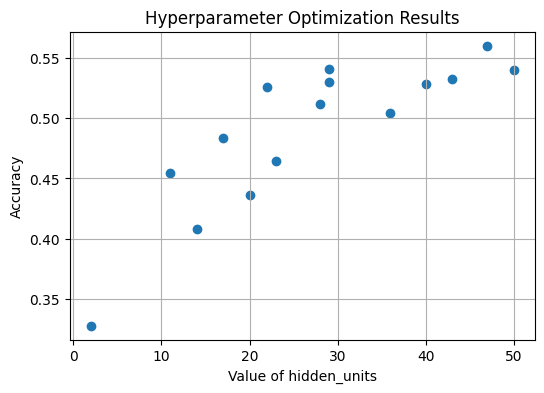

In [21]:
import matplotlib.pyplot as plt

hyperparam_values = [t.params['hidden_units'] for t in complete_trials]
accuracies = [t.value for t in complete_trials]

plt.figure(figsize=(6, 4))
plt.scatter(hyperparam_values, accuracies)
plt.title('Hyperparameter Optimization Results')
plt.xlabel('Value of hidden_units')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

More neurons on the hidden layers is better (when considering the range 5-50). It makes sense!

Few of you might have a problem: we've only allowed 15 trials, but `Optuna` tried twice the same trial (unlikely if you set a big range but likely if you only allowed the range [5; 8] for example. An example: https://i.imgur.com/DceMhuf.png). This is because `Optuna` doesn't check if it already has used the previous set of hyperparameters. To fix this, we can add the following code:

```py
from optuna.trial import TrialState

def objective(trial: optuna.trial.Trial) -> float:
    for previous_trial in trial.study.trials:
        if previous_trial.state == TrialState.COMPLETE and trial.params == previous_trial.params:
            print(f"Duplicated trial: {trial.params}, return {previous_trial.value}")
            return previous_trial.value
    ...
...
```

And even setting n_trials to 5000, we won't have optuna running two "experiments" with the same hyperparameters.

Let's add this and let's also optimize on the learning rate, the number of epochs, the use of batch normalisation layers, and the optimizer's choice.

We also add some manual pruning.

In [22]:
from optuna.exceptions import TrialPruned
from optuna.trial import TrialState

def objective(trial: optuna.trial.Trial) -> float:
    print("New trial")

    for previous_trial in trial.study.trials:
        if previous_trial.state == TrialState.COMPLETE and trial.params == previous_trial.params:
            print(f"Duplicated trial: {trial.params}, return {previous_trial.value}")
            return previous_trial.value
        
    # Set up cross validation
    n_splits: int = 5
    fold = KFold(n_splits=n_splits, shuffle=True, random_state=0)
    scores = [0]*n_splits

    # Manual pruning
    try:
        best_score = trial.study.best_value
    except ValueError:
        best_score = 0

    # Hyperparameters choice
    hidden_units: int = trial.suggest_int('hidden_units', 2, 1000)
    learning_rate: float = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    optimiser: str = trial.suggest_categorical('optimiser', ['SGD', 'Adam'])
    num_epochs: int = trial.suggest_int('epochs', 5, 20)
    batch_norm: bool = trial.suggest_categorical('batch_norm', [True, False])
    use_conv: bool = trial.suggest_categorical('use_conv', [True, False])

    # Loop through data loader data batches
    for fold_idx, (train_idx, valid_idx) in enumerate(fold.split(range(len(TRAIN_DATALOADER.dataset)))):
        # train_idx and valid_idx are numpy arrays of indices of the training and validation sets for this 
        # fold respectively.
        # They do not contain the actual data, but the indices of the data in the dataset.
        # We can use these indices to create a subset of the dataset for this fold with torch.utils.data.Subset.
        # Obviously, if an index is in the validation set, it will not be in the training set. You could
        # check this by printing train_idx and valid_idx and check by yourself.
        
        print(f"Fold {fold_idx+1}/{n_splits}")

        # Create subsets of the dataset for this fold
        sub_train_data = torch.utils.data.Subset(TRAIN_DATALOADER.dataset, train_idx)
        sub_valid_data = torch.utils.data.Subset(TRAIN_DATALOADER.dataset, valid_idx)

        # Create data loaders for this fold
        sub_train_loader = torch.utils.data.DataLoader(sub_train_data, batch_size=BATCH_SIZE, shuffle=True)
        sub_valid_loader = torch.utils.data.DataLoader(sub_valid_data, batch_size=BATCH_SIZE, shuffle=False)
        
        # Generate the model.
        my_model: Net = Net(
            hidden_units=hidden_units,
            batch_norm=batch_norm,
            use_conv=use_conv
        ).to(DEVICE)
        
        for epoch in range(num_epochs):
            # Training of the model.
            # Put model in train mode
            my_model.train()

            # Set up optimizer
            if optimiser == 'SGD':
                optimizer = torch.optim.SGD(my_model.parameters(), lr=learning_rate)
            elif optimiser == 'Adam':
                optimizer = torch.optim.Adam(my_model.parameters(), lr=learning_rate)
            else:
                raise ValueError(f"Unknown optimiser {optimiser}")

            # Set up loss function
            loss_fn = nn.CrossEntropyLoss()
            for X, y in sub_train_loader:
                # 1. Move data to device
                X = X.to(DEVICE)
                y = y.to(DEVICE)

                # 2. Forward pass
                y_pred = my_model(X)

                # 3. Calculate and accumulate loss
                loss = loss_fn(y_pred, y)

                # 4. Optimizer zero grad
                optimizer.zero_grad()

                # 5. Loss backward
                loss.backward()

                # 6. Optimizer step
                optimizer.step()

        # Validation of the model.
        # Put model in eval mode
        my_model.eval()
        
        val_acc = 0
        with torch.no_grad():
            for X, y in sub_valid_loader:
                # 1. Move data to device
                X = X.to(DEVICE)
                y = y.to(DEVICE)

                # 2. Forward pass
                y_pred = my_model(X)
                
                # 3. Compute accuracy
                y_pred_class = y_pred.argmax(dim=1)

                val_acc += (y_pred_class == y).sum()

        scores[fold_idx] = (val_acc.cpu() / len(sub_valid_data))
        # bring it back otherwise, np.mean will not work
        print(f"Fold {fold_idx+1}/{n_splits} accuracy: {scores[fold_idx]}")

        if fold_idx != 5 and np.mean(scores[:fold_idx+1]) < best_score * 0.7:
            print("Pruning trial")
            raise TrialPruned()
    
    return np.mean(scores)

In [23]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, timeout=3600, n_trials=20) 
# - timeout = 3600 -> stops after 60 minutes;
# - n_trials = 20 -> tries 20 different values for the hyperparameter.

pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("\n")
print("--------------------")
print("--------------------")
print("--------------------")
print("\n")
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print(f"\t{key}: {value}")

[I 2026-01-18 14:10:31,999] A new study created in memory with name: no-name-06d917e6-5aa3-4157-88c0-61d78706b8ce


New trial
Fold 1/5
Fold 1/5 accuracy: 0.489871084690094
Fold 2/5
Fold 2/5 accuracy: 0.4806629717350006
Fold 3/5
Fold 3/5 accuracy: 0.4667896628379822
Fold 4/5
Fold 4/5 accuracy: 0.5276752710342407
Fold 5/5
Fold 5/5 accuracy: 0.4833948314189911


[I 2026-01-18 14:10:35,690] Trial 0 finished with value: 0.4896787703037262 and parameters: {'hidden_units': 908, 'learning_rate': 0.0001937188931392921, 'optimiser': 'Adam', 'epochs': 6, 'batch_norm': True, 'use_conv': False}. Best is trial 0 with value: 0.4896787703037262.


New trial
Fold 1/5
Fold 1/5 accuracy: 0.5119705200195312
Fold 2/5
Fold 2/5 accuracy: 0.5745856165885925
Fold 3/5
Fold 3/5 accuracy: 0.5221402049064636
Fold 4/5
Fold 4/5 accuracy: 0.4797047972679138
Fold 5/5
Fold 5/5 accuracy: 0.5922509431838989


[I 2026-01-18 14:10:47,732] Trial 1 finished with value: 0.536130428314209 and parameters: {'hidden_units': 257, 'learning_rate': 0.07846965988618734, 'optimiser': 'SGD', 'epochs': 11, 'batch_norm': False, 'use_conv': True}. Best is trial 1 with value: 0.536130428314209.


New trial
Fold 1/5
Fold 1/5 accuracy: 0.6445671916007996
Fold 2/5
Fold 2/5 accuracy: 0.6648250222206116
Fold 3/5
Fold 3/5 accuracy: 0.6568265557289124
Fold 4/5
Fold 4/5 accuracy: 0.6088560819625854
Fold 5/5
Fold 5/5 accuracy: 0.6254612803459167


[I 2026-01-18 14:11:11,350] Trial 2 finished with value: 0.6401072144508362 and parameters: {'hidden_units': 756, 'learning_rate': 0.00040707045899558106, 'optimiser': 'Adam', 'epochs': 20, 'batch_norm': False, 'use_conv': True}. Best is trial 2 with value: 0.6401072144508362.


New trial
Fold 1/5
Fold 1/5 accuracy: 0.609576404094696
Fold 2/5
Fold 2/5 accuracy: 0.5985267162322998
Fold 3/5
Fold 3/5 accuracy: 0.6346863508224487
Fold 4/5
Fold 4/5 accuracy: 0.61623615026474
Fold 5/5
Fold 5/5 accuracy: 0.5996310114860535


[I 2026-01-18 14:11:31,526] Trial 3 finished with value: 0.6117313504219055 and parameters: {'hidden_units': 501, 'learning_rate': 0.002239863892795507, 'optimiser': 'Adam', 'epochs': 18, 'batch_norm': False, 'use_conv': True}. Best is trial 2 with value: 0.6401072144508362.


New trial
Fold 1/5
Fold 1/5 accuracy: 0.500920832157135
Fold 2/5
Fold 2/5 accuracy: 0.5248618721961975
Fold 3/5
Fold 3/5 accuracy: 0.49630996584892273
Fold 4/5
Fold 4/5 accuracy: 0.46494466066360474
Fold 5/5
Fold 5/5 accuracy: 0.4944649338722229


[I 2026-01-18 14:11:35,686] Trial 4 finished with value: 0.49630045890808105 and parameters: {'hidden_units': 925, 'learning_rate': 2.8105181647291477e-05, 'optimiser': 'SGD', 'epochs': 10, 'batch_norm': True, 'use_conv': False}. Best is trial 2 with value: 0.6401072144508362.


New trial
Fold 1/5
Fold 1/5 accuracy: 0.3830570876598358
Pruning trial


[I 2026-01-18 14:11:36,299] Trial 5 pruned. 


New trial
Fold 1/5
Fold 1/5 accuracy: 0.5561694502830505
Fold 2/5
Fold 2/5 accuracy: 0.5672191381454468
Fold 3/5
Fold 3/5 accuracy: 0.5608856081962585
Fold 4/5
Fold 4/5 accuracy: 0.5682656764984131
Fold 5/5
Fold 5/5 accuracy: 0.5756457448005676


[I 2026-01-18 14:11:40,405] Trial 6 finished with value: 0.5656371116638184 and parameters: {'hidden_units': 886, 'learning_rate': 0.0018320281155430297, 'optimiser': 'SGD', 'epochs': 11, 'batch_norm': False, 'use_conv': False}. Best is trial 2 with value: 0.6401072144508362.


New trial
Fold 1/5
Fold 1/5 accuracy: 0.489871084690094
Fold 2/5
Fold 2/5 accuracy: 0.4567219018936157
Fold 3/5
Fold 3/5 accuracy: 0.5221402049064636
Fold 4/5
Fold 4/5 accuracy: 0.4261992573738098
Fold 5/5
Fold 5/5 accuracy: 0.4188191890716553


[I 2026-01-18 14:11:59,768] Trial 7 finished with value: 0.4627503454685211 and parameters: {'hidden_units': 882, 'learning_rate': 0.0003733434294177231, 'optimiser': 'SGD', 'epochs': 17, 'batch_norm': False, 'use_conv': True}. Best is trial 2 with value: 0.6401072144508362.


New trial
Fold 1/5
Fold 1/5 accuracy: 0.5561694502830505
Fold 2/5
Fold 2/5 accuracy: 0.5432780981063843
Fold 3/5
Fold 3/5 accuracy: 0.39114391803741455
Fold 4/5
Fold 4/5 accuracy: 0.5498154759407043
Fold 5/5
Fold 5/5 accuracy: 0.5830258131027222


[I 2026-01-18 14:12:19,293] Trial 8 finished with value: 0.5246865153312683 and parameters: {'hidden_units': 18, 'learning_rate': 1.2202813270032674e-05, 'optimiser': 'Adam', 'epochs': 19, 'batch_norm': False, 'use_conv': True}. Best is trial 2 with value: 0.6401072144508362.


New trial
Fold 1/5
Fold 1/5 accuracy: 0.5782688856124878
Fold 2/5
Fold 2/5 accuracy: 0.6058931946754456
Fold 3/5
Fold 3/5 accuracy: 0.5701106786727905
Fold 4/5
Fold 4/5 accuracy: 0.5424354076385498
Fold 5/5
Fold 5/5 accuracy: 0.5701106786727905


[I 2026-01-18 14:12:24,410] Trial 9 finished with value: 0.5733637809753418 and parameters: {'hidden_units': 457, 'learning_rate': 0.00012017767575652407, 'optimiser': 'SGD', 'epochs': 16, 'batch_norm': True, 'use_conv': False}. Best is trial 2 with value: 0.6401072144508362.


New trial
Fold 1/5
Fold 1/5 accuracy: 0.32596686482429504
Pruning trial


[I 2026-01-18 14:12:29,130] Trial 10 pruned. 


New trial
Fold 1/5
Fold 1/5 accuracy: 0.6022099256515503
Fold 2/5
Fold 2/5 accuracy: 0.6427255868911743
Fold 3/5
Fold 3/5 accuracy: 0.5350553393363953
Fold 4/5
Fold 4/5 accuracy: 0.5940959453582764
Fold 5/5
Fold 5/5 accuracy: 0.6236162185668945


[I 2026-01-18 14:12:47,537] Trial 11 finished with value: 0.5995405912399292 and parameters: {'hidden_units': 585, 'learning_rate': 0.0025633967405917085, 'optimiser': 'Adam', 'epochs': 16, 'batch_norm': False, 'use_conv': True}. Best is trial 2 with value: 0.6401072144508362.


New trial
Fold 1/5
Fold 1/5 accuracy: 0.5690608024597168
Fold 2/5
Fold 2/5 accuracy: 0.3278084695339203
Fold 3/5
Fold 3/5 accuracy: 0.5793358087539673
Fold 4/5
Fold 4/5 accuracy: 0.5516605377197266
Fold 5/5
Fold 5/5 accuracy: 0.5239852666854858


[I 2026-01-18 14:13:03,213] Trial 12 finished with value: 0.510370135307312 and parameters: {'hidden_units': 443, 'learning_rate': 0.006898711607587293, 'optimiser': 'Adam', 'epochs': 14, 'batch_norm': False, 'use_conv': True}. Best is trial 2 with value: 0.6401072144508362.


New trial
Fold 1/5
Fold 1/5 accuracy: 0.6629834175109863
Fold 2/5
Fold 2/5 accuracy: 0.6224677562713623
Fold 3/5
Fold 3/5 accuracy: 0.6346863508224487
Fold 4/5
Fold 4/5 accuracy: 0.6420664191246033
Fold 5/5
Fold 5/5 accuracy: 0.6420664191246033


[I 2026-01-18 14:13:26,593] Trial 13 finished with value: 0.6408540606498718 and parameters: {'hidden_units': 698, 'learning_rate': 0.0007765076775710487, 'optimiser': 'Adam', 'epochs': 20, 'batch_norm': False, 'use_conv': True}. Best is trial 13 with value: 0.6408540606498718.


New trial
Fold 1/5
Fold 1/5 accuracy: 0.6537753343582153
Fold 2/5
Fold 2/5 accuracy: 0.6593002080917358
Fold 3/5
Fold 3/5 accuracy: 0.6586715579032898
Fold 4/5
Fold 4/5 accuracy: 0.6273062825202942
Fold 5/5
Fold 5/5 accuracy: 0.6420664191246033


[I 2026-01-18 14:13:50,184] Trial 14 finished with value: 0.6482239961624146 and parameters: {'hidden_units': 744, 'learning_rate': 0.0006347964739085728, 'optimiser': 'Adam', 'epochs': 20, 'batch_norm': False, 'use_conv': True}. Best is trial 14 with value: 0.6482239961624146.


New trial
Fold 1/5
Fold 1/5 accuracy: 0.6114180684089661
Fold 2/5
Fold 2/5 accuracy: 0.6114180684089661
Fold 3/5
Fold 3/5 accuracy: 0.5719557404518127
Fold 4/5
Fold 4/5 accuracy: 0.5922509431838989
Fold 5/5
Fold 5/5 accuracy: 0.5516605377197266


[I 2026-01-18 14:14:08,019] Trial 15 finished with value: 0.5877407193183899 and parameters: {'hidden_units': 706, 'learning_rate': 9.382288958795679e-05, 'optimiser': 'Adam', 'epochs': 15, 'batch_norm': False, 'use_conv': True}. Best is trial 14 with value: 0.6482239961624146.


New trial
Fold 1/5
Fold 1/5 accuracy: 0.6335175037384033
Fold 2/5
Fold 2/5 accuracy: 0.6206261515617371
Fold 3/5
Fold 3/5 accuracy: 0.607011079788208
Fold 4/5
Fold 4/5 accuracy: 0.6051660776138306
Fold 5/5
Fold 5/5 accuracy: 0.6051660776138306


[I 2026-01-18 14:14:21,995] Trial 16 finished with value: 0.6142973899841309 and parameters: {'hidden_units': 311, 'learning_rate': 0.0006642465847524282, 'optimiser': 'Adam', 'epochs': 13, 'batch_norm': False, 'use_conv': True}. Best is trial 14 with value: 0.6482239961624146.


New trial
Fold 1/5
Fold 1/5 accuracy: 0.32596686482429504
Pruning trial


[I 2026-01-18 14:14:26,341] Trial 17 pruned. 


New trial
Fold 1/5
Fold 1/5 accuracy: 0.6040515899658203
Fold 2/5
Fold 2/5 accuracy: 0.5230202674865723
Fold 3/5
Fold 3/5 accuracy: 0.5719557404518127
Fold 4/5
Fold 4/5 accuracy: 0.5202952027320862
Fold 5/5
Fold 5/5 accuracy: 0.553505539894104


[I 2026-01-18 14:14:38,294] Trial 18 finished with value: 0.5545656085014343 and parameters: {'hidden_units': 599, 'learning_rate': 5.612366858937709e-05, 'optimiser': 'Adam', 'epochs': 8, 'batch_norm': True, 'use_conv': True}. Best is trial 14 with value: 0.6482239961624146.


New trial
Fold 1/5
Fold 1/5 accuracy: 0.6703498959541321
Fold 2/5
Fold 2/5 accuracy: 0.6445671916007996
Fold 3/5
Fold 3/5 accuracy: 0.61623615026474
Fold 4/5
Fold 4/5 accuracy: 0.5516605377197266
Fold 5/5
Fold 5/5 accuracy: 0.6033210158348083


[I 2026-01-18 14:15:01,451] Trial 19 finished with value: 0.6172269582748413 and parameters: {'hidden_units': 615, 'learning_rate': 0.0013956465093491277, 'optimiser': 'Adam', 'epochs': 20, 'batch_norm': False, 'use_conv': True}. Best is trial 14 with value: 0.6482239961624146.




--------------------
--------------------
--------------------


Study statistics: 
  Number of finished trials:  20
  Number of pruned trials:  3
  Number of complete trials:  17
Best trial:
  Value:  0.6482239961624146
  Params: 
	hidden_units: 744
	learning_rate: 0.0006347964739085728
	optimiser: Adam
	epochs: 20
	batch_norm: False
	use_conv: True


Let's now train the whole model with the optimal hyperparameters that we found with Optuna. We will use the `study.best_params` attribute to get the best hyperparameters. You need to re-train on the whole training dataset!!! Otherwise, you will not get the best accuracy as you're leaving out some data.

In [24]:
study.best_params  # display the best hyperparameters

{'hidden_units': 744,
 'learning_rate': 0.0006347964739085728,
 'optimiser': 'Adam',
 'epochs': 20,
 'batch_norm': False,
 'use_conv': True}

In [25]:
# Create model
MODEL: Net = Net(hidden_units=study.best_params['hidden_units'], batch_norm = study.best_params['batch_norm'], use_conv = study.best_params['use_conv']).to(DEVICE)

# Set number of epochs
NUM_EPOCHS = study.best_params['epochs']

In [26]:
print(MODEL)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=744, bias=True)
  (fc2): Linear(in_features=744, out_features=3, bias=True)
)


In [27]:
optimiser = (
    torch.optim.SGD(MODEL.parameters(), lr=study.best_params['learning_rate']) 
    if study.best_params['optimiser'] == 'SGD' 
    else 
    torch.optim.Adam(MODEL.parameters(), lr=study.best_params['learning_rate'])
)
print(optimiser)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0006347964739085728
    maximize: False
    weight_decay: 0
)


In [28]:
main_train(
    nn.CrossEntropyLoss(), 
    torch.optim.SGD(MODEL.parameters(), lr=study.best_params['learning_rate']) if study.best_params['optimiser'] == 'SGD' 
    else torch.optim.Adam(MODEL.parameters(), lr=study.best_params['learning_rate'])
)

epoch 1/20, train_loss = 3.02e-03, train_acc = 40.60%, time spent during this epoch = 0.32s, total time spent = 0.32s
epoch 2/20, train_loss = 2.31e-03, train_acc = 45.17%, time spent during this epoch = 0.31s, total time spent = 0.63s
epoch 3/20, train_loss = 2.14e-03, train_acc = 50.18%, time spent during this epoch = 0.32s, total time spent = 0.95s
epoch 4/20, train_loss = 1.96e-03, train_acc = 60.40%, time spent during this epoch = 0.31s, total time spent = 1.26s
epoch 5/20, train_loss = 1.83e-03, train_acc = 61.32%, time spent during this epoch = 0.31s, total time spent = 1.57s
epoch 6/20, train_loss = 1.74e-03, train_acc = 65.23%, time spent during this epoch = 0.30s, total time spent = 1.87s
epoch 7/20, train_loss = 1.62e-03, train_acc = 68.25%, time spent during this epoch = 0.33s, total time spent = 2.20s
epoch 8/20, train_loss = 1.54e-03, train_acc = 71.64%, time spent during this epoch = 0.36s, total time spent = 2.56s
epoch 9/20, train_loss = 1.46e-03, train_acc = 72.94%, t

In [29]:
test_our_model()

0.7385621070861816

Our performance went up by more than 10%! (Only 20 trials of hyperparameter optimisation)